In [1]:
##########################################
# ЗАГРУЗКА ДАННЫХ df_master
#########################################

import pandas as pd

df_master = pd.read_csv(r'./df_master_after_redocking.csv', index_col='ligand_id')
#df_master = df_master[df_master['Status'].isin(['Keep', 'Redock'])].copy()
#df_master.to_csv(r'./df_master.csv')

In [2]:
print('Непродоченное значение энергии на лиганде ligand_id 857 для рецептора 8st0:', df_master.loc[857, '8st0'])
print('Пара была передочена с высоким (выше нуля) значением энергии, там очень большой MW, маленький бокс и лиганд попросту на влазит, обнуляем!')
df_master.loc[857, '8st0'] = 0
print('Новое значение энергии на лиганде ligand_id 857 для рецептора 8st0:', df_master.loc[857, '8st0'])

Непродоченное значение энергии на лиганде ligand_id 857 для рецептора 8st0: nan
Пара была передочена с высоким (выше нуля) значением энергии, там очень большой MW, маленький бокс и лиганд попросту на влазит, обнуляем!
Новое значение энергии на лиганде ligand_id 857 для рецептора 8st0: 0.0


In [3]:
#df = pd.read_csv(r'./df_master.csv', index_col='ligand_id')
df = df_master.copy()

In [4]:
#####################################################
# НАБОР СТОЛБЦОВ С ЭНЕРГИЯМИ df_master
####################################################

PROTEINS = ['1m2z', '1pbq', '1xoq', '2rh1',
       '2vt4', '2ydo', '2z5x', '3b66', '3kk6', '3ln1', '3rze', '4djh', '4ey7',
       '4iar', '4mqs', '4n6h', '5cxv', '5i71', '5tvn', '5u09', '5va1', '6cm4',
       '6kpf', '6kux', '6lqa', '6pdj', '6x3x', '6y1z', '7f8y', '7kwe', '7ljd',
       '7wc9', '7xnk', '7ym8', '8e9y', '8ef6', '8fhs', '8pjk', '8st0', '8wty',
       '8xvk', '8yn3', '9eo4', 'V1A']

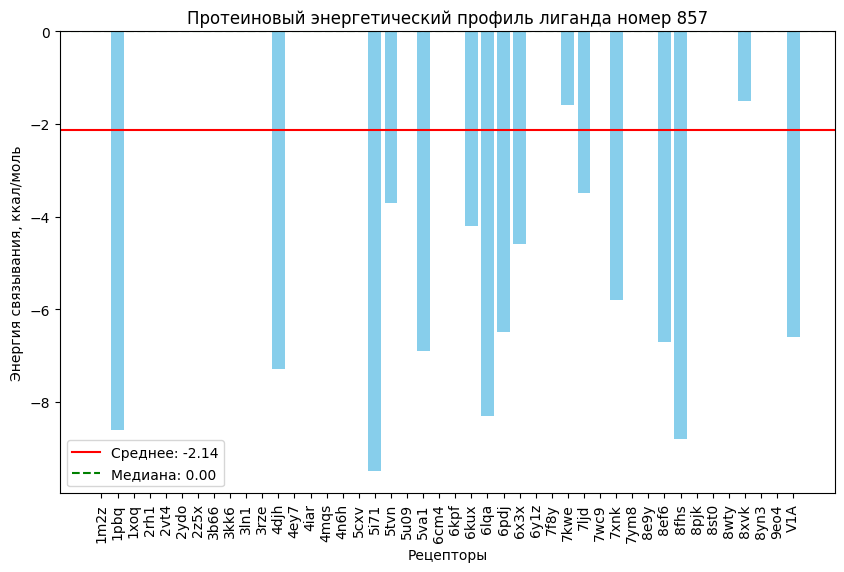

In [5]:
#####################################################
# ПРИМЕР ЭНЕРГЕТИЧЕСКОГО ПРОФИЛЯ ЛИГАНДА (МОЛЕКУЛЫ)
####################################################

import matplotlib.pyplot as plt
import numpy as np

# Выбираем строку по индексу (например, первую строку)
row_index = 857
row = df[PROTEINS].loc[row_index]

# Вычисляем среднее и медиану
mean_val = row.mean()
median_val = row.median()

# Строим гистограмму
plt.figure(figsize=(10, 6))
plt.bar(row.index, row.values, color='skyblue')

# Добавляем линии для среднего и медианы
plt.axhline(y=mean_val, color='r', linestyle='-', label=f'Среднее: {mean_val:.2f}')
plt.axhline(y=median_val, color='g', linestyle='--', label=f'Медиана: {median_val:.2f}')
plt.xticks(rotation=90)

# Добавляем подписи
plt.title(f'Протеиновый энергетический профиль лиганда номер {row_index}')
plt.xlabel('Рецепторы')
plt.ylabel('Энергия связывания, ккал/моль')
plt.legend()

plt.show()

In [6]:
"""
Далее, важно понимать столбец 'Status':
Мы имеем 16498 лигандов в сумме, из них не все гладко дочились, они получили статусы
Keep            10079 - без проблем
Remove           3746 - удаляем по причине того, что там содержатся хелаты, соли и вещества, структуру которых софт для докинга не может обсчитать,
                        либо уже совершенный обсчет считаем некорректным.
Redock           2653 - имели изомеры, которыми пришлось заменить изначальный вариант
Redock_error       20 - изомеры, которые не передочились, и об этом было понятно по явным ошибкам софта для докинга.

Мы оставляем для анализа только категории Keep и Redock.
"""
df['Status'].value_counts()

Status
Keep            10079
Remove           3746
Redock           2653
Redock_error       20
Name: count, dtype: int64

In [7]:
"""
Redock_error - это явные ошибки софта для докинга. Также были и неявные. Мы просто апостериори обнаружили nan-ы в категориях Keep и Redock, 77 штук.
"""
df = df[df['Status'].isin(['Keep', 'Redock'])].copy()
indices_list = df[df[PROTEINS].isna().all(axis=1)].index.tolist()
len(indices_list)

77

In [8]:
"""
Присваиваем им статус 'Error' и убираем из выборки
"""
df.loc[indices_list, 'Status'] = 'Error'
df = df[df['Status'].isin(['Keep', 'Redock'])].copy()

In [9]:
df['Status'].value_counts()

Status
Keep      10002
Redock     2653
Name: count, dtype: int64

In [10]:
"""
Проверяем
"""
df['Status'].value_counts()

Status
Keep      10002
Redock     2653
Name: count, dtype: int64

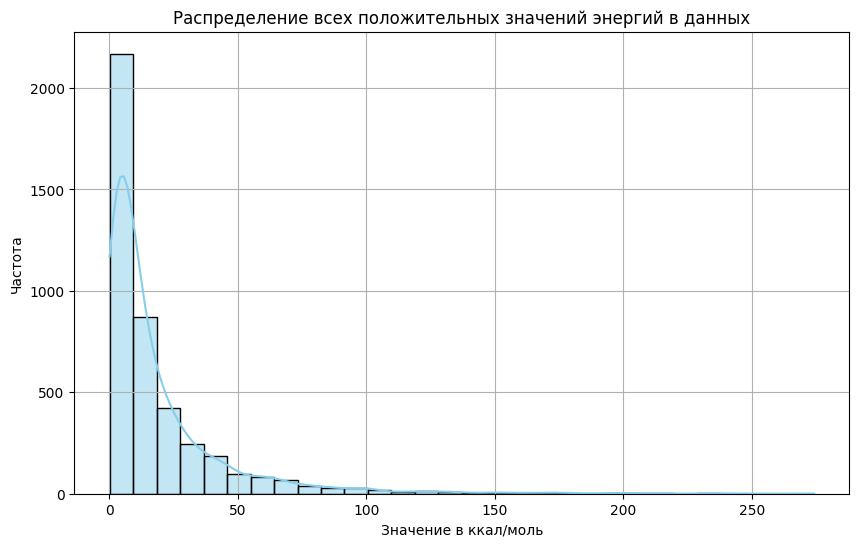

In [11]:
"""
В датасете есть положительные значения энергий. Их меньше процента. По физическому смыслу это сильное отталкивание вещества
с поверхностью кармана рецептора. По биохимическому смыслу это то же самое, что нулевая энергия, то есть отсутствие связывания с рецептором.
Поэтому обычно мы такие значения мы зануляем. Тем не менее, их можно попробовать использовать как признаки для разделения выборки на классы.
Рекомендуется обрезать большие значения до +10 чтобы балансировать с шкалой слева от нуля
"""

import numpy as np
import seaborn as sns

all_positive_values = df[PROTEINS].values.flatten()
all_positive_values = all_positive_values[all_positive_values > 0]  # фильтруем > 0

# 3. Строим единую гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(all_positive_values, kde=True, bins=30, color='skyblue')
plt.title('Распределение всех положительных значений энергий в данных')
plt.xlabel('Значение в ккал/моль')
plt.ylabel('Частота')
plt.grid(True)
plt.savefig('hist.png')
plt.show()

In [12]:
# Зануление положительных энергий
""" Далее зануляем для корректного просчета корреляций"""

df.loc[:, PROTEINS] = df[PROTEINS].apply(lambda x: x.where(x <= 0, 0))

In [13]:
########################################################################################
# МЕТОД СЧИТАЕТ КОРРЕЛЯЦИЮ ДВУХ НАБОРОВ СТОЛБЦОВ И СОЗДАЕТ МАТРИЦУ ПОПАРНЫХ КОРРЕЛЯЦИЙ
#######################################################################################

def calculate_correlation_matrix(df, list1, list2):
    """
    Создает матрицу корреляции между столбцами из двух списков
    
    Параметры:
    df - исходный DataFrame
    list1 - список столбцов (будут строками результирующей матрицы)
    list2 - список столбцов (будут столбцами результирующей матрицы)
    
    Возвращает:
    DataFrame с коэффициентами корреляции Пирсона
    """
    # Проверка наличия столбцов в DataFrame
    missing_cols = [col for col in list1 + list2 if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Столбцы не найдены в DataFrame: {missing_cols}")
    
    # Создаем пустой DataFrame для результатов
    corr_matrix = pd.DataFrame(index=list1, columns=list2)
    
    # Заполняем матрицу коэффициентами корреляции
    for col1 in list1:
        for col2 in list2:
            corr = df[col1].corr(df[col2])
            corr_matrix.loc[col1, col2] = corr
    
    return corr_matrix

In [14]:
# Определяем списки столбцов для расчета корреляций
list1 = PROTEINS
list2 = ['MW, g/mol', '-lgLD50, mol/kg', 'lgLD50, mmol/kg', 'lgLD50, mg/kg', 'volume', 'logP']

# Вычисляем матрицу корреляции
correlation_df = calculate_correlation_matrix(df, list1, list2)

# Выводим результат
print("Матрица корреляций энергий Рецептор - Свойство:")
correlation_df

Матрица корреляций энергий Рецептор - Свойство:


,"MW, g/mol","-lgLD50, mol/kg","lgLD50, mmol/kg","lgLD50, mg/kg",volume,logP
1m2z,0.325227,-0.050616,0.050616,0.073881,0.270027,-0.060075
1pbq,-0.413709,-0.253869,0.253869,0.113249,-0.488411,-0.356611
1xoq,-0.328037,-0.196717,0.196717,0.074931,-0.383134,-0.281876
2rh1,-0.228397,-0.219809,0.219809,0.113994,-0.312087,-0.318758
2vt4,-0.377672,-0.227765,0.227765,0.093425,-0.44253,-0.334533
2ydo,0.237839,-0.07365,0.07365,0.07492,0.179918,-0.17899
2z5x,0.504604,0.077809,-0.077809,0.010955,0.489143,0.045795
3b66,0.496598,0.025989,-0.025989,0.051757,0.439527,0.013653
3kk6,0.100085,-0.107138,0.107138,0.068718,0.031189,-0.221076
3ln1,0.248195,-0.096675,0.096675,0.100321,0.190386,-0.135528


In [15]:
# Глазами была замечена сильная корреляция корреляций: E <-> logP и E <-> токсичность (-lgLD50)
correlation_df['logP'].corr(correlation_df['-lgLD50, mol/kg'])

np.float64(0.973134503714176)

In [16]:
# Первое, что приходит на ум - проверить корреляцию logP с -lgLD50 непосредственно в сырых данных, может быть она тоже высокая?
# Но...
df['-lgLD50, mol/kg'].corr(df['logP'])

np.float64(0.3007768002016643)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


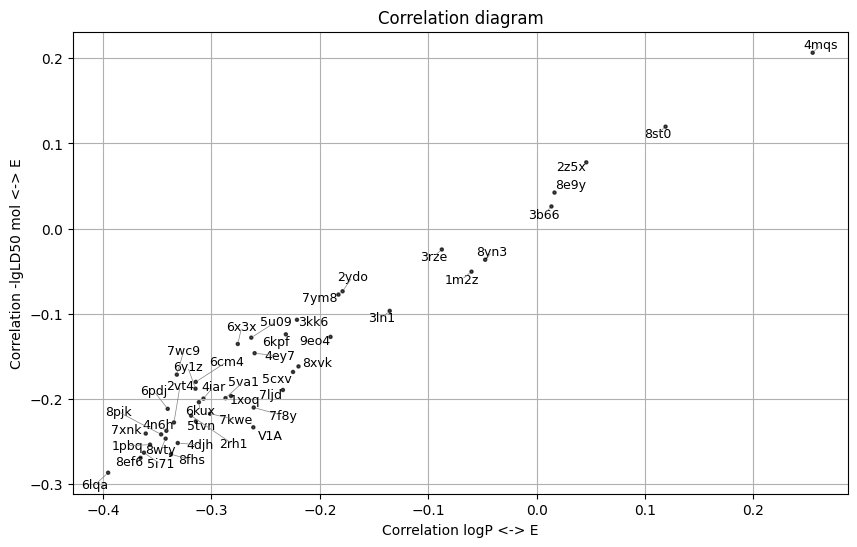

In [17]:
# Отобразим на графике матрицу E <-> logP и E <-> токсичность (-lgLD50)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text  # Установите: pip install adjustText

#col1 = 'MW, g/mol'
col1 = 'logP'

# Предполагаем, что correlation_df уже загружен
correlation_df['labels'] = correlation_df.index  # Подписи берутся из индекса
correlation_df['colors'] = 'black'   # Все точки черные
correlation_df['sizes'] = 5          # Размер точек

# Создаем scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    x=correlation_df[col1],
    y=correlation_df['-lgLD50, mol/kg'],
    c=correlation_df['colors'],
    s=correlation_df['sizes'],
    alpha=0.7
)

# Собираем все подписи в список
texts = []
for i, row in correlation_df.iterrows():
    texts.append(
        plt.text(
            row[col1],  # Изначальная позиция X (без смещения)
            row['-lgLD50, mol/kg'],  # Изначальная позиция Y
            row['labels'],
            fontsize=9,
            ha='center',
            va='center'
        )
    )

# Автоматически раздвигаем подписи, чтобы они не перекрывались
adjust_text(
    texts,
    expand_points=(1.2, 1.5),  # Расширение зоны вокруг точек (x, y)
    expand_text=(1.2, 1.5),     # Расширение зоны вокруг текста
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)  # Стрелки (опционально)
)

plt.xlabel('Correlation logP <-> E')
plt.ylabel('Correlation -lgLD50 mol <-> E')
plt.title('Correlation diagram')
plt.grid(True)
plt.savefig('corr.jpg')
plt.show()

In [18]:
"""
Для дальнейшего анализа понадобятся фингерпринты ECFP4
"""
import time
from pandarallel import pandarallel
from cpuinfo import get_cpu_info
pandarallel.initialize(nb_workers= get_cpu_info()['count']//2, progress_bar=False, verbose=0)

# 2. Генерация фингерпринтов для обеих выборок. Необходимые части библиотек загружаются в память каждого процесса из-за GIL
def smiles_to_fp_morgan(smiles, fp_size=2048, radius=4):
    from rdkit.Chem import rdFingerprintGenerator, MolFromSmiles
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fp_size)
    mol = MolFromSmiles(smiles)
    if mol is None:
        return None
    return mfpgen.GetFingerprint(mol)

time0 = time.time()
df["ecfp4_2048"] = df["Cleaned SMILES"].parallel_apply(smiles_to_fp_morgan)
print(time.time()-time0)

2.813997268676758


In [19]:
"""
Готовая для дальнейшего анализа версия датафрейма
TARGET = '-lgLD50, mol/kg'
Фичи:
PROTEINS (см. ячейку номер 4)
'ecfp4_2048' - fingerprint
"""
TARGET = '-lgLD50, mol/kg'
print('Целевая переменная: Столбец', TARGET)
print('Фичи: столбцы энергий из набора PROTEINS:', PROTEINS)
print('А также столбец ecfp4_2048')
df

Целевая переменная: Столбец -lgLD50, mol/kg
Фичи: столбцы энергий из набора PROTEINS: ['1m2z', '1pbq', '1xoq', '2rh1', '2vt4', '2ydo', '2z5x', '3b66', '3kk6', '3ln1', '3rze', '4djh', '4ey7', '4iar', '4mqs', '4n6h', '5cxv', '5i71', '5tvn', '5u09', '5va1', '6cm4', '6kpf', '6kux', '6lqa', '6pdj', '6x3x', '6y1z', '7f8y', '7kwe', '7ljd', '7wc9', '7xnk', '7ym8', '8e9y', '8ef6', '8fhs', '8pjk', '8st0', '8wty', '8xvk', '8yn3', '9eo4', 'V1A']
А также столбец ecfp4_2048


,Pubchem CID,Canonical SMILES,Original SMILES,Cleaned SMILES,"MW, g/mol","-lgLD50, mol/kg","lgLD50, mmol/kg","lgLD50, mg/kg",Status,PAINS_filter,...,8ef6,8fhs,8pjk,8st0,8wty,8xvk,8yn3,9eo4,V1A,ecfp4_2048
ligand_id,,,,,,,,,,,,,,,,,,,,,
1,5453,S=P(N1CC1)(N1CC1)N1CC1,C1CN1P(=S)(N2CC2)N3CC3,S=P(N1CC1)(N1CC1)N1CC1,189.224,4.115608,-1.115608,1.161368,Keep,False,...,-3.7,-3.6,-4.2,-3.4,-4.5,-4.0,-3.8,-4.2,-3.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4091,CN(C)C(=N)N=C(N)N,CN(C)C(=N)NC(=N)N.Cl,CN(C)C(=N)NC(=N)N,129.167,2.855879,0.144121,2.255273,Keep,False,...,-4.7,-5.1,-4.8,-4.6,-5.2,-5.4,-4.9,-5.6,-4.7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,8784,O=C(O)C=Cc1ccccc1,c1(\C=C\C(O)=O)ccccc1,O=C(O)/C=C/c1ccccc1,148.161,2.590950,0.409050,2.579784,Keep,False,...,-6.7,-5.9,-6.2,-7.3,-6.6,-6.3,-6.4,-7.3,-5.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,10364,Cc1ccc(C(C)C)cc1O,CC(C)c1ccc(C)c(O)c1,Cc1ccc(C(C)C)cc1O,150.221,3.273641,-0.273641,1.903090,Keep,False,...,-6.3,-5.7,-6.5,-6.6,-7.1,-5.8,-6.4,-7.3,-5.6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,65036,C=CCSS(=O)CC=C,C=CC[S@@](SCC=C)=O,C=CCS[S@@](=O)CC=C,162.279,3.432111,-0.432111,1.778151,Redock,False,...,-4.0,-3.5,-4.5,-4.4,-4.3,-4.6,-4.6,-4.3,-3.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16493,45156,CC1CCCCN1CCCOC(=O)Cc1ccccc1,c1(CC(OCCC[N@@]2[C@@H](CCCC2)C)=O)ccccc1,C[C@@H]1CCCCN1CCCOC(=O)Cc1ccccc1,275.392,3.723948,-0.723948,1.716003,Keep,False,...,-7.1,-6.2,-7.0,-7.3,-8.2,-6.2,-6.8,-7.9,-5.8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
16494,56507,CCCC#CC(O)(C(=O)OC1CCN(C)CC1)c1ccccc1,c1([C@@](C(OC2CCN(C)CC2)=O)(C#CCCC)O)ccccc1,CCCC#C[C@](O)(C(=O)OC1CCN(C)CC1)c1ccccc1,315.413,4.156457,-1.156457,1.342423,Redock,False,...,-7.1,-7.5,-7.6,-4.5,-8.2,-6.4,-6.8,-8.5,-6.3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
16495,56513,CN1CCC(OC(=O)C(O)(C#Cc2ccccc2)c2ccccc2)CC1,c1([C@@](C(OC2CCN(C)CC2)=O)(C#Cc2ccccc2)O)ccccc1,CN1CCC(OC(=O)[C@@](O)(C#Cc2ccccc2)c2ccccc2)CC1,349.430,4.429417,-1.429417,1.113943,Redock,False,...,-8.5,-8.8,-8.6,-5.4,-10.1,-7.1,-8.3,-8.9,-7.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
